In [1]:
pip install pandas numpy matplotlib seaborn geopandas scikit-learn xgboost folium


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

# Load CSV file
df = pd.read_csv('crime.csv')  

# Basic inspection
print(df.shape)
print(df.head())
print(df.info())
print(df.describe())


(470278, 19)
   incident_id         offense_id  OFFENSE_CODE  OFFENSE_CODE_EXTENSION  \
0  20226000193  20226000193299900          2999                       0   
1     20223319     20223319299900          2999                       0   
2     20223093     20223093299900          2999                       0   
3     20224000     20224000299900          2999                       0   
4     20223956     20223956299900          2999                       0   

           OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID FIRST_OCCURRENCE_DATE  \
0  criminal-mischief-other     public-disorder  1/4/2022 11:30:00 AM   
1  criminal-mischief-other     public-disorder   1/3/2022 6:45:00 AM   
2  criminal-mischief-other     public-disorder   1/3/2022 1:00:00 AM   
3  criminal-mischief-other     public-disorder   1/3/2022 7:47:00 PM   
4  criminal-mischief-other     public-disorder   1/3/2022 5:06:00 PM   

   LAST_OCCURRENCE_DATE         REPORTED_DATE    INCIDENT_ADDRESS      GEO_X  \
0  1/4/2022 12:00:00 PM

In [3]:
df['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(df['FIRST_OCCURRENCE_DATE'], errors='coerce')
df = df.dropna(subset=['FIRST_OCCURRENCE_DATE', 'GEO_LAT', 'GEO_LON'])

# Optional: Filter to recent 5 years
df = df[df['FIRST_OCCURRENCE_DATE'].dt.year >= 2019]


In [4]:
df['Hour'] = df['FIRST_OCCURRENCE_DATE'].dt.hour
df['DayOfWeek'] = df['FIRST_OCCURRENCE_DATE'].dt.day_name()
df['Month'] = df['FIRST_OCCURRENCE_DATE'].dt.month
df['Year'] = df['FIRST_OCCURRENCE_DATE'].dt.year
df['Weekday'] = df['FIRST_OCCURRENCE_DATE'].dt.weekday
df['Weekend'] = df['Weekday'].isin([5, 6]).astype(int)
print(df[['Hour', 'DayOfWeek', 'Month', 'Year', 'Weekday', 'Weekend']].head())


   Hour DayOfWeek  Month  Year  Weekday  Weekend
0    11   Tuesday      1  2022        1        0
1     6    Monday      1  2022        0        0
2     1    Monday      1  2022        0        0
3    19    Monday      1  2022        0        0
4    17    Monday      1  2022        0        0


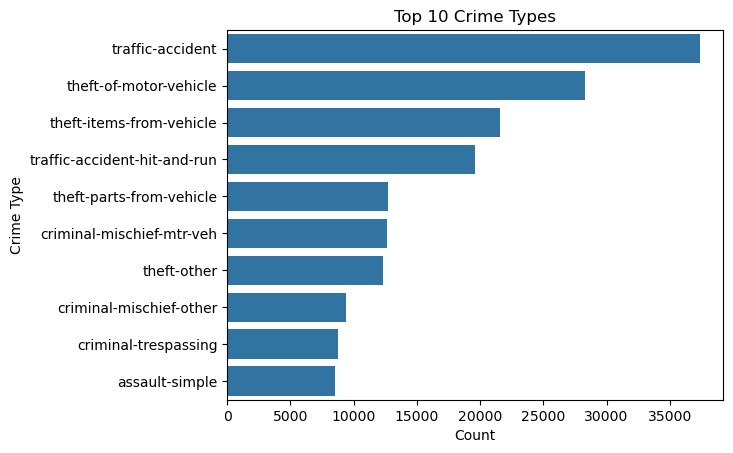

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

top_offenses = df['OFFENSE_TYPE_ID'].value_counts().head(10)
sns.barplot(y=top_offenses.index, x=top_offenses.values)
plt.title("Top 10 Crime Types")
plt.xlabel("Count")
plt.ylabel("Crime Type")
plt.show()


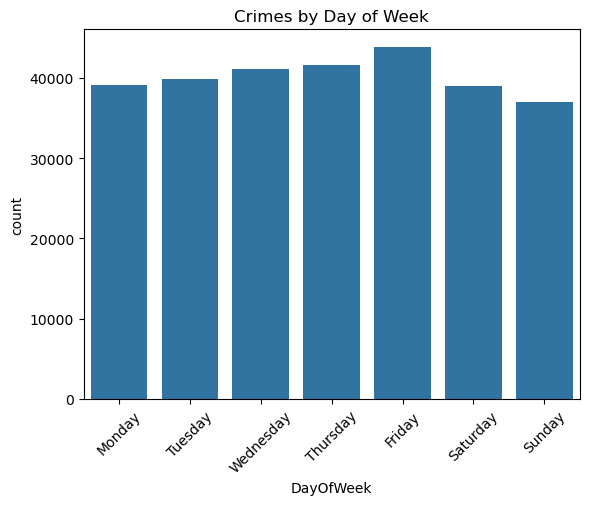

In [6]:
sns.countplot(data=df, x='DayOfWeek', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Crimes by Day of Week")
plt.xticks(rotation=45)
plt.show()


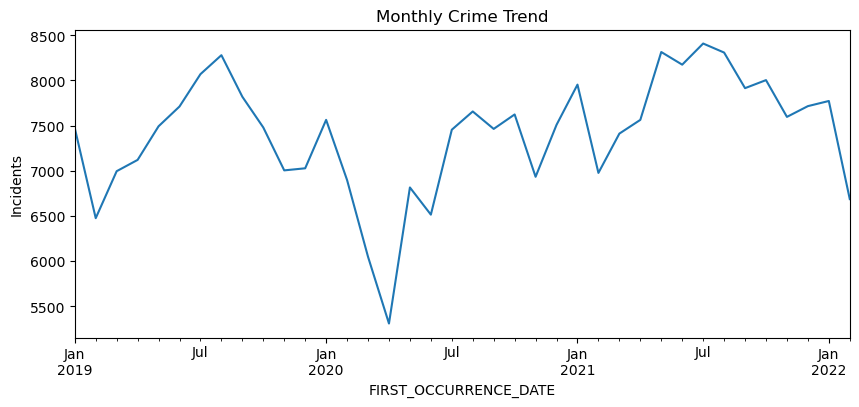

In [7]:
monthly_trend = df.set_index('FIRST_OCCURRENCE_DATE').resample('M').size()
monthly_trend.plot(title='Monthly Crime Trend', figsize=(10, 4))
plt.ylabel("Incidents")
plt.show()


In [8]:
top_neighborhoods = df['NEIGHBORHOOD_ID'].value_counts().nlargest(5).index.tolist()
df['is_hotspot'] = df['NEIGHBORHOOD_ID'].isin(top_neighborhoods).astype(int)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

features = ['Hour', 'Month', 'GEO_LAT', 'GEO_LON', 'Weekend']
X = df[features]
y = df['is_hotspot']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44661
           1       1.00      1.00      1.00     11643

    accuracy                           1.00     56304
   macro avg       1.00      1.00      1.00     56304
weighted avg       1.00      1.00      1.00     56304



In [10]:
from xgboost import XGBClassifier
xgb = XGBClassifier(eval_metric='logloss')  # <- cleaner
xgb.fit(X_train, y_train)
print(classification_report(y_test, xgb.predict(X_test)))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44661
           1       0.99      1.00      1.00     11643

    accuracy                           1.00     56304
   macro avg       1.00      1.00      1.00     56304
weighted avg       1.00      1.00      1.00     56304



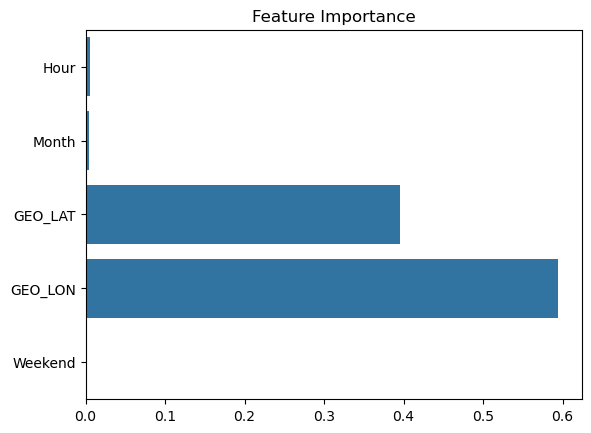

In [11]:
importances = model.feature_importances_
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()


In [12]:
from sklearn.metrics import roc_auc_score
probs = model.predict_proba(X_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, probs))


ROC AUC Score: 0.999945649709705


In [13]:
import folium

hotspots = df[df['is_hotspot'] == 1].sample(500)
crime_map = folium.Map(location=[hotspots['GEO_LAT'].mean(), hotspots['GEO_LON'].mean()], zoom_start=12)

for _, row in hotspots.iterrows():
    folium.CircleMarker(
        location=[row['GEO_LAT'], row['GEO_LON']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.6
    ).add_to(crime_map)

crime_map  # this will render inside Jupyter


In [14]:
from folium.plugins import HeatMap

heat_data = df[['GEO_LAT', 'GEO_LON']].dropna().values.tolist()
map_heat = folium.Map(location=[df['GEO_LAT'].mean(), df['GEO_LON'].mean()], zoom_start=12)
HeatMap(heat_data[:5000]).add_to(map_heat)
map_heat
